In [2]:
cd ATML-PA-2/DAN/

[Errno 2] No such file or directory: 'ATML-PA-2/DAN/'
/kaggle/working/ATML-PA-2/DAN


In [77]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier
from utils.evaluation import evaluate_ds
import types
import numpy as np

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")
domains = ['Real World', 'Art', 'Clipart', 'Product']

In [7]:
# import torch
# import numpy as np
# from sklearn.metrics import (
#     confusion_matrix,
#     classification_report,
#     accuracy_score
# )
# import seaborn as sns

# def evaluate_ds(ds, model, device, domain_name=None, class_names=None):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     loader = torch.utils.data.DataLoader(ds, shuffle=False, batch_size=32)

#     with torch.inference_mode():
#         for X, Y in loader:
#             X, Y = X.to(device), Y.to(device)
#             logits = model(X)  
#             preds = torch.argmax(logits, dim=1)
#             all_preds.append(preds.cpu())
#             all_labels.append(Y.cpu())

#     y_true = torch.cat(all_labels).numpy()
#     y_pred = torch.cat(all_preds).numpy()


#     acc = accuracy_score(y_true, y_pred)
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

#     if domain_name:
#         print(f"\n=== Evaluation for {domain_name} Domain ===")
#     print(f"Accuracy: {acc*100:.2f}%")
#     print("Confusion Matrix:\n")
#     sns.heatmap(cm, cmap="Blues")
#     plt.show()
#     print("Classification Report:\n", report)

#     return {
#         'domain': domain_name,
#         'accuracy': acc,
#         'confusion_matrix': cm,
#         'classification_report': report,
#         'y_true': y_true,
#         'y_pred': y_pred
#     }


In [96]:
import os
import argparse
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet152, ResNet152_Weights
from architecture import DANLoss

# --------------------------
# Utility Functions
# --------------------------

import torch
from tqdm import trange

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score
)
import seaborn as sns


def accuracy_fn(logits, labels):
    return (torch.argmax(logits, dim=1) == labels).sum().item()

def train_step(source_loader, target_loader, model, optimizer, loss_fn, accuracy_fn, device):
    model.train()
    
    total_supervised = 0
    total_mkmmd = 0
   
    for (X_s, Y_s), (X_t, _) in zip(source_loader, target_loader):
        X_s, Y_s, X_t = X_s.to(device), Y_s.to(device), X_t.to(device)
        
        optimizer.zero_grad()
        logits, source_features = model(X_s, return_features=True)
        _, target_features = model(X_t, return_features=True)
        
        supervised, scaled_mkmmd = loss_fn(source_features, target_features, logits, Y_s)
        loss = supervised + scaled_mkmmd
        loss.backward()
        optimizer.step()
       
        total_supervised += supervised.item()
        total_mkmmd += scaled_mkmmd.item()

    n = len(source_loader.dataset)
    
    avg_supervised = total_supervised / n
    avg_mkmmd = total_mkmmd / n
    avg_loss = avg_supervised + avg_mkmmd
    
    return avg_loss, avg_supervised, avg_mkmmd


def train(source_loader, target_loader, test_loader, epochs, optimizer, model, loss_fn, accuracy_fn, scheduler device):
    source_losses = []
    supervised_losses = []
    mkmmd_losses = []
    train_accs = []
    test_accs = []

    for epoch in trange(epochs, desc="Training"):
        print(f"\nEpoch {epoch+1}/{epochs}")  
        loss_fn.scale = min(loss_fn.scale * scheduler, 2**15)
        model.to(device)

        avg_loss, avg_supervised, avg_mkmmd, = train_step(
            source_loader, target_loader, model, optimizer, loss_fn, accuracy_fn, device
        )
        test_acc_target = evaluate_accuracy(test_loader, model,  device)
        train_acc_source = evaluate_accuracy(source_loader, model, device)

        source_losses.append(avg_loss)
        supervised_losses.append(avg_supervised)
        mkmmd_losses.append(avg_mkmmd)
        train_accs.append(train_acc_source)
        
        test_accs.append(test_acc_target)
        print(f"\nTrain loss: {avg_loss:.5f} | Supervised: {avg_supervised:.5f} | MK-MMD: {avg_mkmmd:.5f} | Source train acc: {train_acc_source*100:.2f}% | Target test acc={test_acc_target*100:.2f}%\n", flush=True)

    return source_losses, supervised_losses, mkmmd_losses, train_accs, test_accs

def evaluate_accuracy(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)

            logits= model(X)  
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(Y.cpu())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    return accuracy_score(y_true, y_pred)

def train_workflow(model, src_dataset, tgt_dataset, val_dataset, config, device):
    epochs         = config.get('epochs', 5)
    lr             = config.get('lr', 1e-5)
    weight_decay   = config.get('weight_decay', 0.0)
    batch_size     = config.get('batch_size', 32)
    momentum       = config.get('momentum', 0.0)
    sigmas         = config.get('sigmas', [1.0])
    scale          = config.get('scale', [1.0])
    scheduler      = config.get('scheduler', 1.25)
    
    loss_fn = DANLoss(sigmas=sigmas, scale=scale)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

    source_loader = torch.utils.data.DataLoader(src_dataset, batch_size, shuffle=True, drop_last=True)
    target_loader = torch.utils.data.DataLoader(tgt_dataset, batch_size, shuffle=True, drop_last=True)
    test_loader   = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)
    
    train(source_loader, target_loader, test_loader, epochs, optimizer, model, loss_fn, accuracy_fn, scheduler, device)

    





SyntaxError: invalid syntax (4104858506.py, line 59)

In [70]:
import matplotlib.pyplot as plt

def analysis(config, model, cache_source, cache_target):
        
    torch.manual_seed(100)
    
    cache_source_train, cache_source_test = torch.utils.data.random_split(cache_source, [0.8,0.2])
    cache_target_train, cache_target_test = torch.utils.data.random_split(cache_target, [0.8,0.2])
  
    train_workflow(model, cache_source_train, cache_target_train, cache_target_test, config, device)

    print("Evaluating on target domain test set")
    evaluate_ds(cache_target_test, model, device)
    plt.show()

    print("Evaluating on source domain test set")
    evaluate_ds(cache_source_test, model, device)
    plt.show()

    print("Evaluating on source domain train set")
    evaluate_ds(cache_source_train, model, device)
    plt.show()

    latents_s, _ = get_features(model[:-1], cache_source, batchsize=32, device=device)
    latents_t, _ = get_features(model[:-1], cache_target, batchsize=32, device=device)

    latents_s = latents_s.flatten(start_dim=1)
    latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(len(latents_s), dtype=torch.long),
        torch.ones(len(latents_t), dtype=torch.long)
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target (Test Sets)")
    plt.show()

In [65]:
def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

def combine_caches(caches):
    return torch.utils.data.ConcatDataset(caches)

def make_cache(domains, model, transforms=None, layer_name='layer3'):
    ds = OfficeHomeDataset(root_dir, csv_file, domains, transforms)
    return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=32)

def build_model(truncate_from):
    model = resnet_classifier( 
        num_classes=len(classes),
    )
    return _truncate_resnet_from(model, truncate_from)

def adjust_model_forward(model, include_layers=("layer4", "fc")):
    def forward_impl(self, x, return_features=False):
        f4 = self.layer4(x)
        f5 = self.avgpool(f4)
        f6 = self.flatten(f5)
        out = self.fc(f6)

        outputs = []
        if "layer4" in include_layers:
            outputs.append(f4)
        if "fc" in include_layers:
            outputs.append(out)

        if return_features == True:
            return out, outputs
       
        return out

    model.forward = types.MethodType(forward_impl, model)
    return model


In [8]:
model = resnet_classifier(num_classes=len(classes))

cache_store = {}
for domain in domains:
    cache_store[domain] = make_cache([domain], model, transform, "layer3")
    print(f"Cached {domain}")

Precomputing up to layer3: 100%|██████████| 137/137 [01:48<00:00,  1.26it/s]


Cached Real World


Precomputing up to layer3: 100%|██████████| 76/76 [00:42<00:00,  1.80it/s]


Cached Art


Precomputing up to layer3: 100%|██████████| 137/137 [05:33<00:00,  2.43s/it] 


Cached Clipart


Precomputing up to layer3: 100%|██████████| 139/139 [00:57<00:00,  2.42it/s]


Cached Product


In [56]:
pairs = [
    # Low-shift
    ("Product", "Real World"),
    ("Art", "Clipart"),

    # Medium-shift
    ("Product", "Art"),
    ("Art", "Real World"),

    # High-shift
    ("Real World", "Clipart"),
    ("Product", "Clipart")
]

Training:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/5

Train loss: 1.73332 | Supervised: 1.73323 | MK-MMD: 0.00009 | Source train acc: 86.78% | Target test acc=65.33%



Training:  20%|██        | 1/5 [00:12<00:49, 12.43s/it]


Epoch 2/5

Train loss: 0.36919 | Supervised: 0.36904 | MK-MMD: 0.00015 | Source train acc: 97.19% | Target test acc=72.90%



Training:  40%|████      | 2/5 [00:24<00:37, 12.39s/it]


Epoch 3/5

Train loss: 0.13661 | Supervised: 0.13636 | MK-MMD: 0.00025 | Source train acc: 99.33% | Target test acc=73.36%



Training:  60%|██████    | 3/5 [00:37<00:24, 12.37s/it]


Epoch 4/5

Train loss: 0.06482 | Supervised: 0.06434 | MK-MMD: 0.00048 | Source train acc: 99.71% | Target test acc=73.13%



Training:  80%|████████  | 4/5 [00:49<00:12, 12.40s/it]


Epoch 5/5

Train loss: 0.03792 | Supervised: 0.03747 | MK-MMD: 0.00045 | Source train acc: 99.71% | Target test acc=74.05%



Training: 100%|██████████| 5/5 [01:01<00:00, 12.39s/it]

Evaluating on target domain test set


Accuracy: 74.05%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.8800    0.9565    0.9167        23
           1     0.9048    1.0000    0.9500        19
           2     0.9000    0.7500    0.8182        12
           3     0.8333    0.7143    0.7692        21
           4     1.0000    1.0000    1.0000        26
           5     0.8182    0.6000    0.6923        15
           6     0.6923    0.7500    0.7200        12
           7     0.8182    0.9474    0.8780        19
           8     0.8462    1.0000    0.9167        11
           9     0.8421    1.0000    0.9143        16
          10     0.7143    0.8333    0.7692        12
          11     0.4375    0.3182    0.3684        22
          12     0.3846    0.5000    0.4348        10
          13     0.9000    0.6000    0.7200        15
          14     0.7500    0.7500    0.7500        12
          15     0.5000    0.7000    0.5833        10
          16     0.85

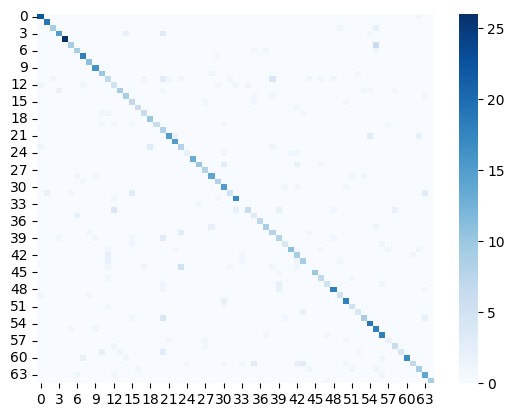

Evaluating on source domain test set
Accuracy: 92.33%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9000    1.0000    0.9474        18
           1     0.9643    0.9643    0.9643        28
           2     0.9167    0.9167    0.9167        12
           3     0.9000    1.0000    0.9474         9
           4     1.0000    1.0000    1.0000         6
           5     0.8000    0.7273    0.7619        11
           6     1.0000    0.8333    0.9091         6
           7     0.8750    1.0000    0.9333        14
           8     0.9524    1.0000    0.9756        20
           9     1.0000    0.8750    0.9333         8
          10     1.0000    0.8333    0.9091        18
          11     0.8889    0.8000    0.8421        10
          12     0.7857    0.7333    0.7586        15
          13     0.9091    0.9524    0.9302        21
          14     0.9412    1.0000    0.9697        16
          15     1.0000    0.9375    0

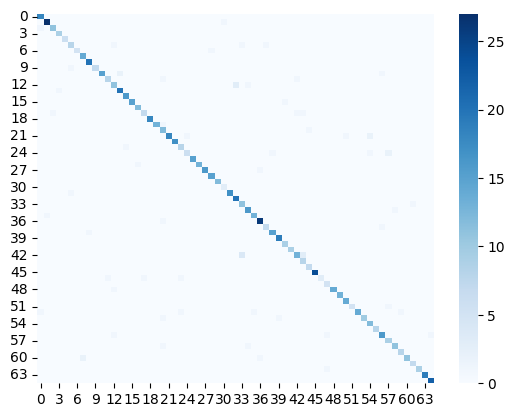

Evaluating on source domain train set
Accuracy: 99.72%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        61
           1     1.0000    1.0000    1.0000        71
           2     1.0000    1.0000    1.0000        50
           3     1.0000    1.0000    1.0000        34
           4     1.0000    1.0000    1.0000        38
           5     1.0000    1.0000    1.0000        51
           6     1.0000    1.0000    1.0000        41
           7     1.0000    1.0000    1.0000        67
           8     1.0000    1.0000    1.0000        61
           9     1.0000    1.0000    1.0000        48
          10     1.0000    1.0000    1.0000        81
          11     1.0000    1.0000    1.0000        55
          12     0.9873    0.9630    0.9750        81
          13     1.0000    1.0000    1.0000        67
          14     1.0000    1.0000    1.0000        59
          15     0.9853    1.0000    

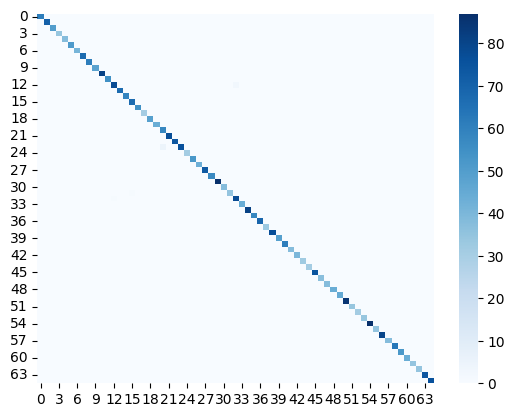

progress : 1|139
progress : 6|139
progress : 11|139
progress : 16|139
progress : 21|139
progress : 26|139
progress : 31|139
progress : 36|139
progress : 41|139
progress : 46|139
progress : 51|139
progress : 56|139
progress : 61|139
progress : 66|139
progress : 71|139
progress : 76|139
progress : 81|139
progress : 86|139
progress : 91|139
progress : 96|139
progress : 101|139
progress : 106|139
progress : 111|139
progress : 116|139
progress : 121|139
progress : 126|139
progress : 131|139
progress : 136|139
progress : 139|139
progress : 1|137
progress : 6|137
progress : 11|137
progress : 16|137
progress : 21|137
progress : 26|137
progress : 31|137
progress : 36|137
progress : 41|137
progress : 46|137
progress : 51|137
progress : 56|137
progress : 61|137
progress : 66|137
progress : 71|137
progress : 76|137
progress : 81|137
progress : 86|137
progress : 91|137
progress : 96|137
progress : 101|137
progress : 106|137
progress : 111|137
progress : 116|137
progress : 121|137
progress : 126|137

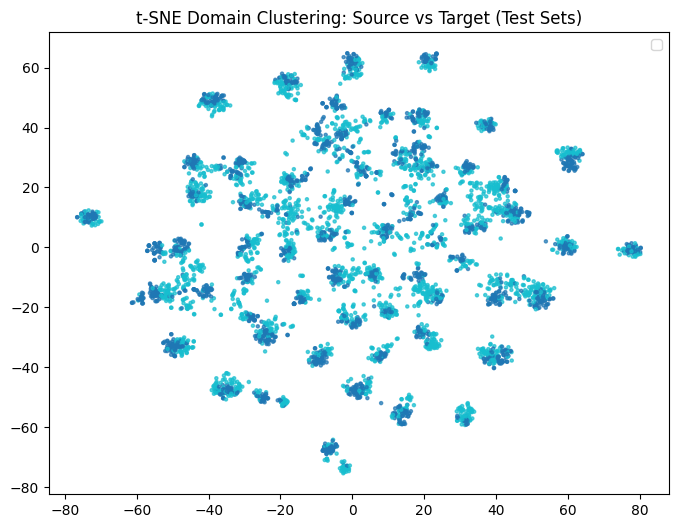

In [81]:
config = {'epochs': 5, 
          'lr':1e-3, 
          'batch_size':128, 
          'weight_decay':1e-2, 
          'sigmas':[2 * 10**i for i in np.linspace(-16, 16, 33)], 
          'scale':16
          }

source, target = ("Product", "Real World")
model = build_model(truncate_from='layer3')
adjust_model_forward(model, include_layers=["fc", "layer4"])
model.layer4.grad = True 

analysis(config, model, cache_store[source], cache_store[target])

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.89033 | Supervised: 1.89003 | MK-MMD: 0.00030 | Source train acc: 84.58% | Target test acc=42.04%



Training:  10%|█         | 1/10 [00:13<02:03, 13.73s/it]


Epoch 2/10

Train loss: 0.51811 | Supervised: 0.51791 | MK-MMD: 0.00020 | Source train acc: 93.63% | Target test acc=45.59%



Training:  20%|██        | 2/10 [00:27<01:49, 13.69s/it]


Epoch 3/10

Train loss: 0.23730 | Supervised: 0.23703 | MK-MMD: 0.00027 | Source train acc: 98.18% | Target test acc=46.16%



Training:  30%|███       | 3/10 [00:41<01:35, 13.69s/it]


Epoch 4/10

Train loss: 0.11686 | Supervised: 0.11623 | MK-MMD: 0.00064 | Source train acc: 99.36% | Target test acc=47.08%



Training:  40%|████      | 4/10 [00:54<01:22, 13.69s/it]


Epoch 5/10

Train loss: 0.07020 | Supervised: 0.06921 | MK-MMD: 0.00099 | Source train acc: 99.45% | Target test acc=46.74%



Training:  50%|█████     | 5/10 [01:08<01:08, 13.69s/it]


Epoch 6/10

Train loss: 0.05097 | Supervised: 0.04968 | MK-MMD: 0.00129 | Source train acc: 99.71% | Target test acc=48.22%



Training:  60%|██████    | 6/10 [01:22<00:54, 13.69s/it]


Epoch 7/10

Train loss: 0.04136 | Supervised: 0.03942 | MK-MMD: 0.00194 | Source train acc: 99.68% | Target test acc=47.65%



Training:  70%|███████   | 7/10 [01:35<00:40, 13.66s/it]


Epoch 8/10

Train loss: 0.03298 | Supervised: 0.03036 | MK-MMD: 0.00262 | Source train acc: 99.74% | Target test acc=48.11%



Training:  80%|████████  | 8/10 [01:49<00:27, 13.66s/it]


Epoch 9/10

Train loss: 0.02916 | Supervised: 0.02616 | MK-MMD: 0.00299 | Source train acc: 99.68% | Target test acc=47.54%



Training:  90%|█████████ | 9/10 [02:03<00:13, 13.64s/it]


Epoch 10/10

Train loss: 0.03067 | Supervised: 0.02469 | MK-MMD: 0.00598 | Source train acc: 99.74% | Target test acc=48.00%



Training: 100%|██████████| 10/10 [02:16<00:00, 13.66s/it]

Evaluating on target domain test set


Accuracy: 48.00%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.6000    0.7500    0.6667         8
           1     0.6923    0.7500    0.7200        12
           2     0.7500    0.2727    0.4000        11
           3     0.6667    0.1429    0.2353        14
           4     1.0000    0.6400    0.7805        25
           5     0.6250    0.2632    0.3704        19
           6     0.6364    0.3500    0.4516        20
           7     0.6875    0.6875    0.6875        16
           8     0.4706    0.5714    0.5161        14
           9     0.4286    0.1500    0.2222        20
          10     0.6400    0.7273    0.6809        22
          11     0.0000    0.0000    0.0000         9
          12     0.6000    0.6316    0.6154        19
          13     0.3333    0.2500    0.2857         8
          14     0.7273    0.8000    0.7619        10
          15     0.0667    0.1000    0.0800        10
          16     1.00

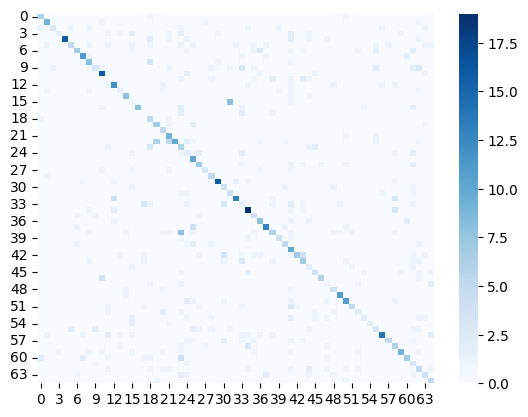

Evaluating on source domain test set
Accuracy: 84.50%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9545    0.9545    0.9545        22
           1     1.0000    1.0000    1.0000        18
           2     0.8571    0.9231    0.8889        13
           3     0.8125    0.8667    0.8387        15
           4     0.9524    1.0000    0.9756        20
           5     0.9286    0.8667    0.8966        15
           6     0.8125    1.0000    0.8966        13
           7     0.9286    1.0000    0.9630        13
           8     1.0000    1.0000    1.0000        11
           9     0.8889    1.0000    0.9412        16
          10     1.0000    0.7143    0.8333        14
          11     0.5833    0.7778    0.6667         9
          12     0.6429    0.5625    0.6000        16
          13     0.7647    0.9286    0.8387        14
          14     0.8571    1.0000    0.9231        12
          15     0.6923    0.7500    0

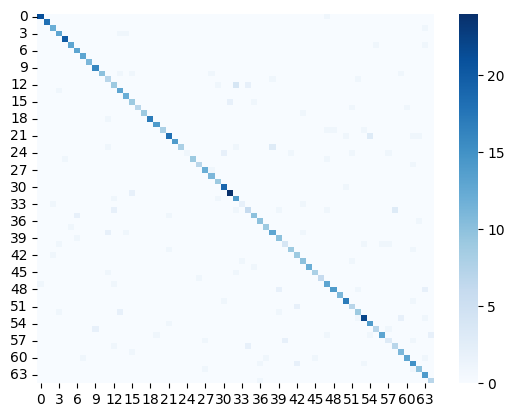

Evaluating on source domain train set
Accuracy: 99.74%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9846    1.0000    0.9922        64
           1     1.0000    1.0000    1.0000        81
           2     1.0000    1.0000    1.0000        51
           3     1.0000    1.0000    1.0000        68
           4     1.0000    1.0000    1.0000        79
           5     1.0000    1.0000    1.0000        63
           6     0.9853    1.0000    0.9926        67
           7     1.0000    1.0000    1.0000        60
           8     1.0000    1.0000    1.0000        57
           9     1.0000    1.0000    1.0000        83
          10     1.0000    0.9878    0.9939        82
          11     1.0000    1.0000    1.0000        56
          12     0.9412    1.0000    0.9697        48
          13     0.9841    1.0000    0.9920        62
          14     1.0000    1.0000    1.0000        61
          15     1.0000    1.0000    

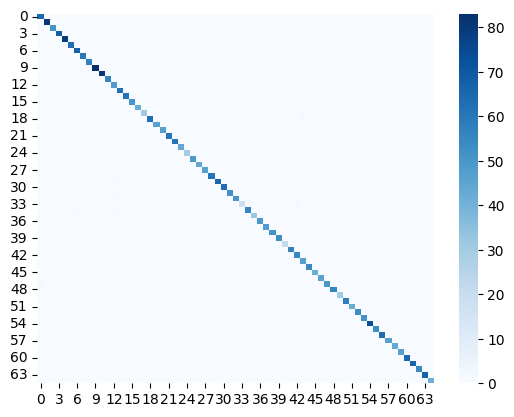

progress : 1|137
progress : 6|137
progress : 11|137
progress : 16|137
progress : 21|137
progress : 26|137
progress : 31|137
progress : 36|137
progress : 41|137
progress : 46|137
progress : 51|137
progress : 56|137
progress : 61|137
progress : 66|137
progress : 71|137
progress : 76|137
progress : 81|137
progress : 86|137
progress : 91|137
progress : 96|137
progress : 101|137
progress : 106|137
progress : 111|137
progress : 116|137
progress : 121|137
progress : 126|137
progress : 131|137
progress : 136|137
progress : 137|137
progress : 1|137
progress : 6|137
progress : 11|137
progress : 16|137
progress : 21|137
progress : 26|137
progress : 31|137
progress : 36|137
progress : 41|137
progress : 46|137
progress : 51|137
progress : 56|137
progress : 61|137
progress : 66|137
progress : 71|137
progress : 76|137
progress : 81|137
progress : 86|137
progress : 91|137
progress : 96|137
progress : 101|137
progress : 106|137
progress : 111|137
progress : 116|137
progress : 121|137
progress : 126|137

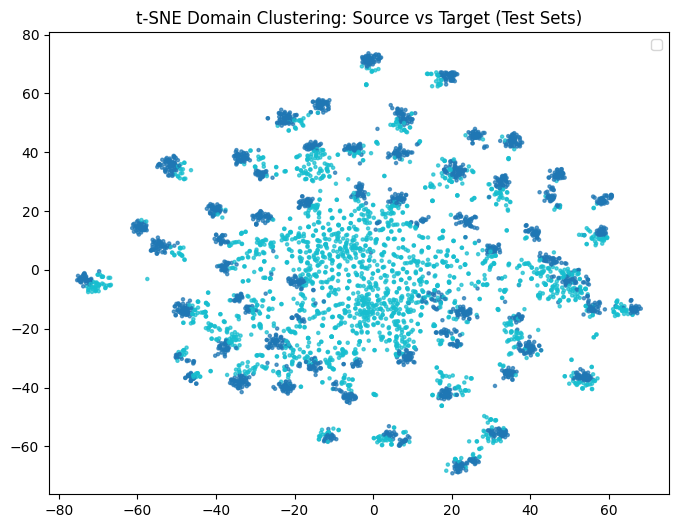

In [89]:
config = {'epochs': 10, 
          'lr':1e-3, 
          'batch_size':64, 
          'weight_decay':1e-1, 
          'sigmas':[2 * 10**i for i in np.linspace(-16, 16, 33)], 
          'scale':8
          }

source, target = ("Real World", "Clipart")
model = build_model(truncate_from='layer3')
adjust_model_forward(model, include_layers=["fc", "layer4"])
model.layer4.grad = True

analysis(config, model, cache_store[source], cache_store[target])

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 3.08488 | Supervised: 3.08466 | MK-MMD: 0.00022 | Source train acc: 62.34% | Target test acc=46.61%



Training:  10%|█         | 1/10 [00:05<00:46,  5.13s/it]


Epoch 2/10

Train loss: 1.19033 | Supervised: 1.19023 | MK-MMD: 0.00009 | Source train acc: 90.89% | Target test acc=67.28%



Training:  20%|██        | 2/10 [00:10<00:40,  5.10s/it]


Epoch 3/10

Train loss: 0.55897 | Supervised: 0.55884 | MK-MMD: 0.00014 | Source train acc: 95.05% | Target test acc=70.95%



Training:  30%|███       | 3/10 [00:15<00:35,  5.09s/it]


Epoch 4/10

Train loss: 0.28213 | Supervised: 0.28176 | MK-MMD: 0.00037 | Source train acc: 98.59% | Target test acc=73.48%



Training:  40%|████      | 4/10 [00:20<00:30,  5.09s/it]


Epoch 5/10

Train loss: 0.14585 | Supervised: 0.14566 | MK-MMD: 0.00019 | Source train acc: 99.48% | Target test acc=75.09%



Training:  50%|█████     | 5/10 [00:25<00:25,  5.08s/it]


Epoch 6/10

Train loss: 0.08250 | Supervised: 0.08180 | MK-MMD: 0.00070 | Source train acc: 99.69% | Target test acc=74.28%



Training:  60%|██████    | 6/10 [00:30<00:20,  5.09s/it]


Epoch 7/10

Train loss: 0.05417 | Supervised: 0.05344 | MK-MMD: 0.00074 | Source train acc: 99.64% | Target test acc=75.09%



Training:  70%|███████   | 7/10 [00:35<00:15,  5.09s/it]


Epoch 8/10

Train loss: 0.04592 | Supervised: 0.04465 | MK-MMD: 0.00127 | Source train acc: 99.64% | Target test acc=75.55%



Training:  80%|████████  | 8/10 [00:40<00:10,  5.09s/it]


Epoch 9/10

Train loss: 0.03927 | Supervised: 0.03766 | MK-MMD: 0.00161 | Source train acc: 99.69% | Target test acc=75.09%



Training:  90%|█████████ | 9/10 [00:45<00:05,  5.09s/it]


Epoch 10/10

Train loss: 0.03249 | Supervised: 0.02987 | MK-MMD: 0.00263 | Source train acc: 99.69% | Target test acc=75.32%



Training: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]

Evaluating on target domain test set


Accuracy: 75.32%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9444    0.9714        18
           1     0.8667    0.9286    0.8966        14
           2     0.7333    0.7857    0.7586        14
           3     0.6957    0.8000    0.7442        20
           4     1.0000    1.0000    1.0000        21
           5     0.5000    0.7333    0.5946        15
           6     0.5652    0.7647    0.6500        17
           7     0.8000    1.0000    0.8889        16
           8     1.0000    1.0000    1.0000        18
           9     1.0000    1.0000    1.0000        15
          10     0.6667    0.9000    0.7660        20
          11     0.5455    0.4000    0.4615        15
          12     0.3889    0.5385    0.4516        13
          13     0.8571    0.6000    0.7059        20
          14     0.8182    0.8182    0.8182        11
          15     0.6000    0.5000    0.5455        12
          16     0.71

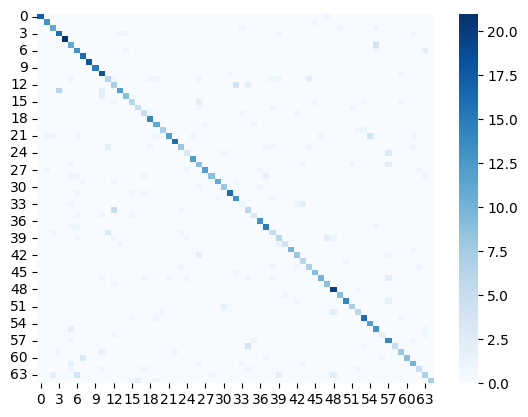

Evaluating on source domain test set


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 76.91%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9474    1.0000    0.9730        18
           1     0.8333    0.7143    0.7692         7
           2     0.8000    0.6667    0.7273         6
           3     0.7500    0.7500    0.7500         8
           4     1.0000    0.8571    0.9231        14
           5     0.7200    0.9000    0.8000        20
           6     0.7500    1.0000    0.8571         9
           7     0.7500    1.0000    0.8571         6
           8     0.7143    0.8333    0.7692         6
           9     0.8095    0.9444    0.8718        18
          10     0.5000    0.8333    0.6250         6
          11     0.3636    0.8000    0.5000         5
          12     0.5000    0.3000    0.3750        10
          13     0.8571    0.6667    0.7500         9
          14     0.9167    0.8462    0.8800        13
          15     1.0000    1.0000    1.0000         1
          16     1.00

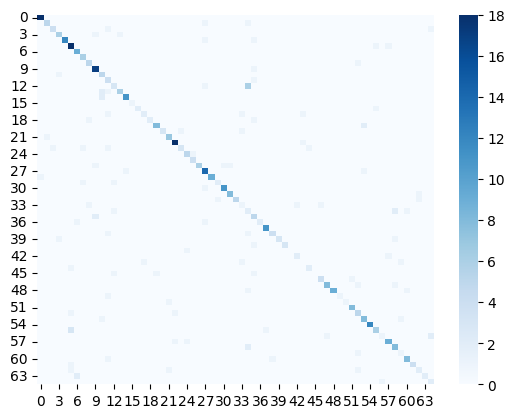

Evaluating on source domain train set
Accuracy: 99.69%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        56
           1     1.0000    1.0000    1.0000        34
           2     1.0000    1.0000    1.0000        21
           3     1.0000    1.0000    1.0000        32
           4     1.0000    1.0000    1.0000        61
           5     1.0000    1.0000    1.0000        79
           6     1.0000    1.0000    1.0000        31
           7     1.0000    1.0000    1.0000        27
           8     1.0000    1.0000    1.0000        14
           9     1.0000    1.0000    1.0000        58
          10     1.0000    1.0000    1.0000        63
          11     1.0000    1.0000    1.0000        20
          12     0.9444    1.0000    0.9714        34
          13     1.0000    1.0000    1.0000        31
          14     1.0000    1.0000    1.0000        27
          15     1.0000    0.9545    

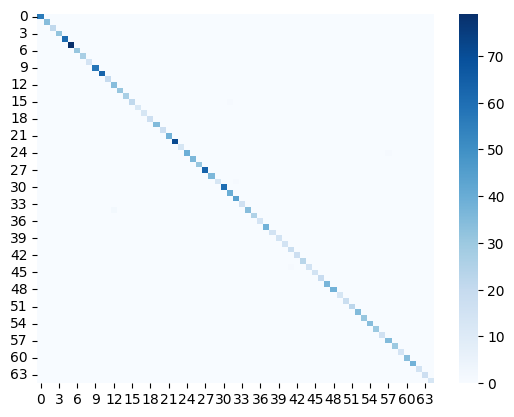

progress : 1|76
progress : 6|76
progress : 11|76
progress : 16|76
progress : 21|76
progress : 26|76
progress : 31|76
progress : 36|76
progress : 41|76
progress : 46|76
progress : 51|76
progress : 56|76
progress : 61|76
progress : 66|76
progress : 71|76
progress : 76|76
progress : 76|76
progress : 1|137
progress : 6|137
progress : 11|137
progress : 16|137
progress : 21|137
progress : 26|137
progress : 31|137
progress : 36|137
progress : 41|137
progress : 46|137
progress : 51|137
progress : 56|137
progress : 61|137
progress : 66|137
progress : 71|137
progress : 76|137
progress : 81|137
progress : 86|137
progress : 91|137
progress : 96|137
progress : 101|137
progress : 106|137
progress : 111|137
progress : 116|137
progress : 121|137
progress : 126|137
progress : 131|137
progress : 136|137
progress : 137|137


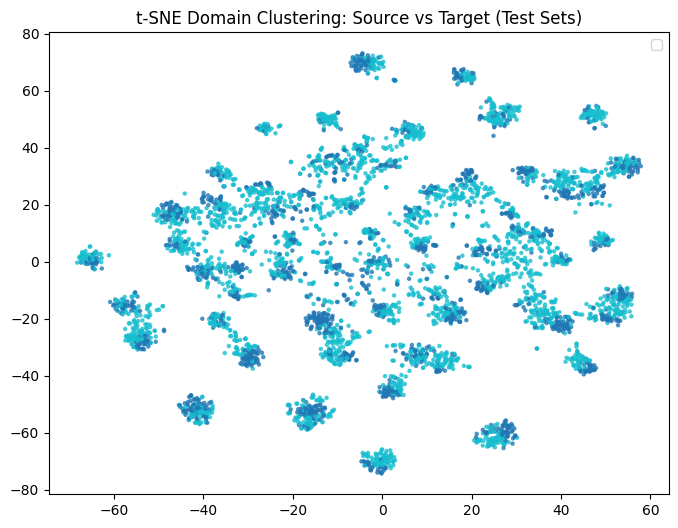

In [90]:
config = {'epochs': 10, 
          'lr':1e-3, 
          'batch_size':128, 
          'weight_decay':1e-1, 
          'sigmas':[2 * 10**i for i in np.linspace(-16, 16, 33)], 
          'scale':16
          }

source, target = ("Art", "Real World")
model = build_model(truncate_from='layer3')
adjust_model_forward(model, include_layers=["fc"])
model.layer4.grad = False

analysis(config, model, cache_store[source], cache_store[target])

In [91]:
sources = ["Art", "Real World", "Product"]
target = "Clipart"
# #benchmark for domain adaptation
source_ds = combine_caches([cache_store[domain] for domain in sources])
target_ds = cache_store[target]

torch.manual_seed(100)
_, benchmark = torch.utils.data.random_split(target_ds, [0.8, 0.2])

Training:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20

Train loss: 0.27666 | Supervised: 0.27666 | MK-MMD: 0.00000 | Source train acc: 30.44% | Target test acc=9.20%



Training:   5%|▌         | 1/20 [00:06<02:09,  6.82s/it]


Epoch 2/20

Train loss: 0.19558 | Supervised: 0.19558 | MK-MMD: 0.00000 | Source train acc: 47.95% | Target test acc=25.29%



Training:  10%|█         | 2/20 [00:13<02:01,  6.77s/it]


Epoch 3/20

Train loss: 0.14984 | Supervised: 0.14984 | MK-MMD: 0.00000 | Source train acc: 64.38% | Target test acc=29.89%



Training:  15%|█▌        | 3/20 [00:20<01:56,  6.85s/it]


Epoch 4/20

Train loss: 0.11186 | Supervised: 0.11186 | MK-MMD: 0.00000 | Source train acc: 71.57% | Target test acc=34.48%



Training:  20%|██        | 4/20 [00:27<01:50,  6.92s/it]


Epoch 5/20

Train loss: 0.09089 | Supervised: 0.09089 | MK-MMD: 0.00000 | Source train acc: 75.20% | Target test acc=35.06%



Training:  25%|██▌       | 5/20 [00:34<01:42,  6.87s/it]


Epoch 6/20

Train loss: 0.07420 | Supervised: 0.07420 | MK-MMD: 0.00000 | Source train acc: 76.80% | Target test acc=37.93%



Training:  30%|███       | 6/20 [00:40<01:34,  6.78s/it]


Epoch 7/20

Train loss: 0.07113 | Supervised: 0.07113 | MK-MMD: 0.00000 | Source train acc: 77.97% | Target test acc=35.63%



Training:  35%|███▌      | 7/20 [00:47<01:28,  6.83s/it]


Epoch 8/20

Train loss: 0.06090 | Supervised: 0.06089 | MK-MMD: 0.00001 | Source train acc: 80.49% | Target test acc=34.48%



Training:  40%|████      | 8/20 [00:54<01:21,  6.80s/it]


Epoch 9/20

Train loss: 0.05588 | Supervised: 0.05586 | MK-MMD: 0.00002 | Source train acc: 82.72% | Target test acc=39.66%



Training:  45%|████▌     | 9/20 [01:01<01:14,  6.80s/it]


Epoch 10/20

Train loss: 0.04721 | Supervised: 0.04720 | MK-MMD: 0.00001 | Source train acc: 82.32% | Target test acc=39.08%



Training:  50%|█████     | 10/20 [01:08<01:08,  6.84s/it]


Epoch 11/20

Train loss: 0.04952 | Supervised: 0.04947 | MK-MMD: 0.00005 | Source train acc: 84.19% | Target test acc=35.06%



Training:  55%|█████▌    | 11/20 [01:15<01:01,  6.88s/it]


Epoch 12/20

Train loss: 0.04998 | Supervised: 0.04993 | MK-MMD: 0.00005 | Source train acc: 85.49% | Target test acc=37.93%



Training:  60%|██████    | 12/20 [01:21<00:53,  6.74s/it]


Epoch 13/20

Train loss: 0.04122 | Supervised: 0.04115 | MK-MMD: 0.00007 | Source train acc: 85.93% | Target test acc=41.38%



Training:  65%|██████▌   | 13/20 [01:28<00:47,  6.83s/it]


Epoch 14/20

Train loss: 0.03917 | Supervised: 0.03900 | MK-MMD: 0.00017 | Source train acc: 86.14% | Target test acc=41.95%



Training:  70%|███████   | 14/20 [01:35<00:40,  6.82s/it]


Epoch 15/20

Train loss: 0.04249 | Supervised: 0.04222 | MK-MMD: 0.00027 | Source train acc: 87.03% | Target test acc=42.53%



Training:  75%|███████▌  | 15/20 [01:42<00:34,  6.81s/it]


Epoch 16/20

Train loss: 0.03183 | Supervised: 0.03153 | MK-MMD: 0.00029 | Source train acc: 87.71% | Target test acc=42.53%



Training:  80%|████████  | 16/20 [01:49<00:27,  6.82s/it]


Epoch 17/20

Train loss: 0.03334 | Supervised: 0.03321 | MK-MMD: 0.00013 | Source train acc: 88.69% | Target test acc=41.95%



Training:  85%|████████▌ | 17/20 [01:56<00:20,  6.83s/it]


Epoch 18/20

Train loss: 0.02950 | Supervised: 0.02857 | MK-MMD: 0.00092 | Source train acc: 90.18% | Target test acc=41.95%



Training:  90%|█████████ | 18/20 [02:02<00:13,  6.83s/it]


Epoch 19/20

Train loss: 0.02764 | Supervised: 0.02673 | MK-MMD: 0.00091 | Source train acc: 90.07% | Target test acc=43.10%



Training:  95%|█████████▌| 19/20 [02:09<00:06,  6.78s/it]


Epoch 20/20

Train loss: 0.02917 | Supervised: 0.02821 | MK-MMD: 0.00096 | Source train acc: 89.55% | Target test acc=42.53%



Training: 100%|██████████| 20/20 [02:16<00:00,  6.81s/it]

Evaluating on target domain test set
Accuracy: 42.53%
Confusion Matrix:




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667         1
           1     0.0000    0.0000    0.0000         1
           2     0.2500    1.0000    0.4000         1
           3     0.0000    0.0000    0.0000         4
           4     1.0000    0.3333    0.5000         3
           5     0.7500    0.6000    0.6667         5
           6     0.0000    0.0000    0.0000         2
           7     0.4000    1.0000    0.5714         2
           8     0.2500    0.3333    0.2857         3
           9     0.0000    0.0000    0.0000         1
          10     0.5000    0.5000    0.5000         4
          11     0.0000    0.0000    0.0000         4
          12     0.5000    0.3333    0.4000         6
          13     0.0000    0.0000    0.0000         1
          15     0.0000    0.0000    0.0000         3
          16     0.0000    0.0000    0.0000         4
          18     0.0000    0.0000    0.0000         0
   

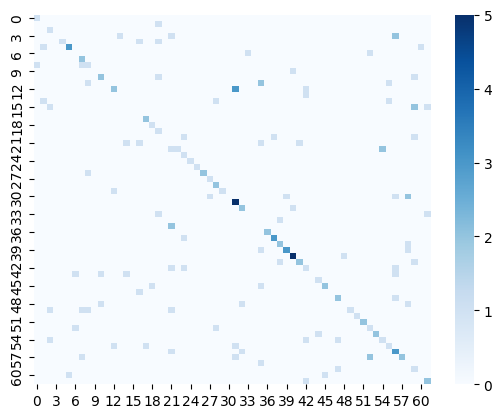

Evaluating on source domain test set
Accuracy: 80.84%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9500    0.8837    0.9157        43
           1     0.9565    0.8800    0.9167        50
           2     0.5208    0.9259    0.6667        27
           3     0.7419    0.8846    0.8070        26
           4     0.9787    1.0000    0.9892        46
           5     0.7455    0.8542    0.7961        48
           6     0.7917    0.6786    0.7308        28
           7     0.8864    1.0000    0.9398        39
           8     0.9722    0.8974    0.9333        39
           9     0.9286    0.9512    0.9398        41
          10     0.8167    0.8750    0.8448        56
          11     1.0000    0.5185    0.6829        27
          12     0.5758    0.5135    0.5429        37
          13     0.7805    0.8000    0.7901        40
          14     0.9512    0.9512    0.9512        41
          15     0.9444    0.5862    0

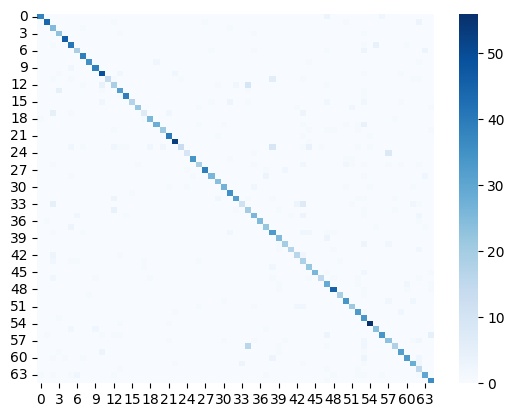

Evaluating on source domain train set
Accuracy: 89.55%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.9689    0.9541    0.9614       196
           1     0.9581    0.9683    0.9632       189
           2     0.6283    0.9524    0.7571       126
           3     0.8618    0.9357    0.8973       140
           4     0.9881    0.9651    0.9765       172
           5     0.9194    0.8953    0.9072       191
           6     0.9318    0.8849    0.9077       139
           7     0.9290    0.9730    0.9505       148
           8     0.9695    0.9769    0.9732       130
           9     0.9837    0.9526    0.9679       190
          10     0.9296    0.9519    0.9406       208
          11     0.9462    0.6875    0.7964       128
          12     0.7975    0.7784    0.7879       167
          13     0.9108    0.8720    0.8910       164
          14     0.9726    0.9660    0.9693       147
          15     0.9106    0.8058    

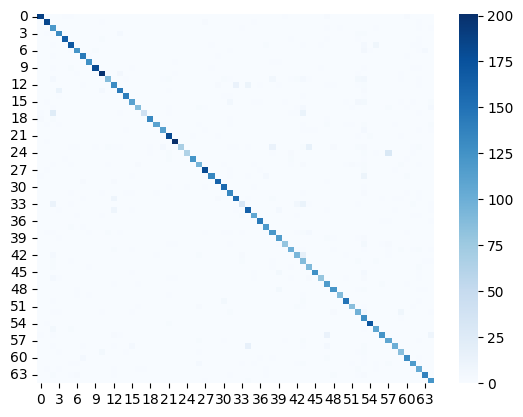

progress : 1|351
progress : 6|351
progress : 11|351
progress : 16|351
progress : 21|351
progress : 26|351
progress : 31|351
progress : 36|351
progress : 41|351
progress : 46|351
progress : 51|351
progress : 56|351
progress : 61|351
progress : 66|351
progress : 71|351
progress : 76|351
progress : 81|351
progress : 86|351
progress : 91|351
progress : 96|351
progress : 101|351
progress : 106|351
progress : 111|351
progress : 116|351
progress : 121|351
progress : 126|351
progress : 131|351
progress : 136|351
progress : 141|351
progress : 146|351
progress : 151|351
progress : 156|351
progress : 161|351
progress : 166|351
progress : 171|351
progress : 176|351
progress : 181|351
progress : 186|351
progress : 191|351
progress : 196|351
progress : 201|351
progress : 206|351
progress : 211|351
progress : 216|351
progress : 221|351
progress : 226|351
progress : 231|351
progress : 236|351
progress : 241|351
progress : 246|351
progress : 251|351
progress : 256|351
progress : 261|351
progress : 266|

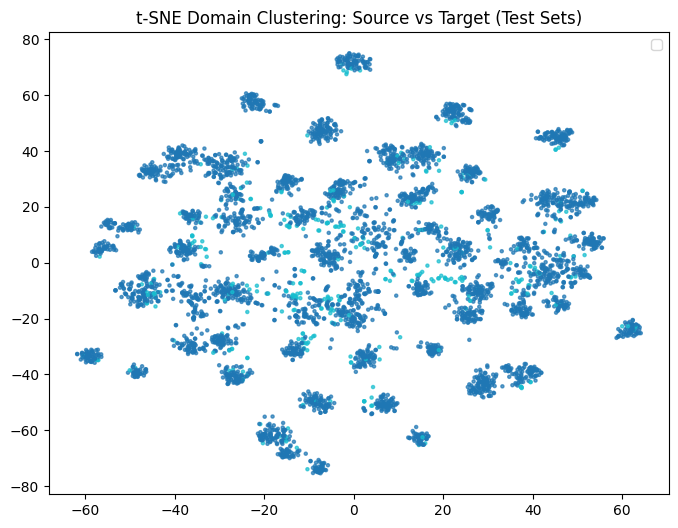

In [111]:
config = {'epochs': 20, 
          'lr':8e-4, 
          'batch_size':128, 
          'weight_decay':1e-3, 
          'sigmas':[2 * 10**i for i in np.linspace(-16, 16, 16)], 
          'scale':0.5,
          'scheduler':1.0
          }


model = build_model(truncate_from='layer3')
adjust_model_forward(model, include_layers=["fc", 'layer4'])
model.layer4.grad = True

analysis(config, model, source_ds, benchmark)